# **1. Import Library**

---



In [ ]:
!pip install yfinance
!pip install seaborn
!pip install matplotlib

In [ ]:
# Import library yang dibutuhkan
import numpy as np  # Operasi matematika dan array
import pandas as pd  # Manipulasi data (CSV, Excel, dll)
from sklearn.preprocessing import MinMaxScaler  # Normalisasi data
from sklearn.metrics import mean_squared_error  # Evaluasi error model
from tensorflow.keras.models import Sequential  # Model neural network linear
from tensorflow.keras.layers import LSTM, Dense, Dropout  # Layer-layer model
import yfinance as yf  # Ambil data saham dari Yahoo Finance
import seaborn as sns  # Visualisasi statistik
import matplotlib.pyplot as plt  # Visualisasi grafik
import matplotlib.dates as mdates  # Format tanggal untuk grafik

# **2. Import Data IHSG**

---



In [ ]:
# Tentukan tanggal awal dan akhir untuk mengambil data historis IHSG (Indeks Harga Saham Gabungan)
start_date = "2017-01-01"
end_data = "2025-07-23"  # (Catatan: 'end_data' harusnya 'end_date' agar konsisten)

# Ambil data saham IHSG dari Yahoo Finance menggunakan simbol ^JKSE
data = yf.Ticker("^JKSE")

# Ambil data historis (harian) dari tanggal yang ditentukan
data = data.history(start=start_date, end=end_data)

# Hapus kolom 'Dividends' karena tidak dibutuhkan dalam analisis harga
del data['Dividends']

# Hapus kolom 'Stock Splits' karena juga tidak relevan untuk prediksi harga IHSG
del data['Stock Splits']

# Salin data hasil download ke variabel baru untuk digunakan dalam forecasting
forecastData = data.copy()

# Tampilkan 5 baris terakhir dari data historis IHSG
data.tail()


,Open,High,Low,Close,Volume
Date,,,,,
2025-07-11 00:00:00+07:00,7036.295898,7055.794922,7026.487793,7047.437988,165301900
2025-07-14 00:00:00+07:00,7130.535156,7136.295898,7071.344238,7097.150879,205642100
2025-07-15 00:00:00+07:00,7122.083008,7161.835938,7079.000000,7140.474121,199389400
2025-07-16 00:00:00+07:00,7182.645020,7216.813965,7142.861816,7192.018066,227976400
2025-07-17 00:00:00+07:00,7229.259766,7291.563965,7226.117188,7287.020996,0


# **3. Close Prize Visualization**

---



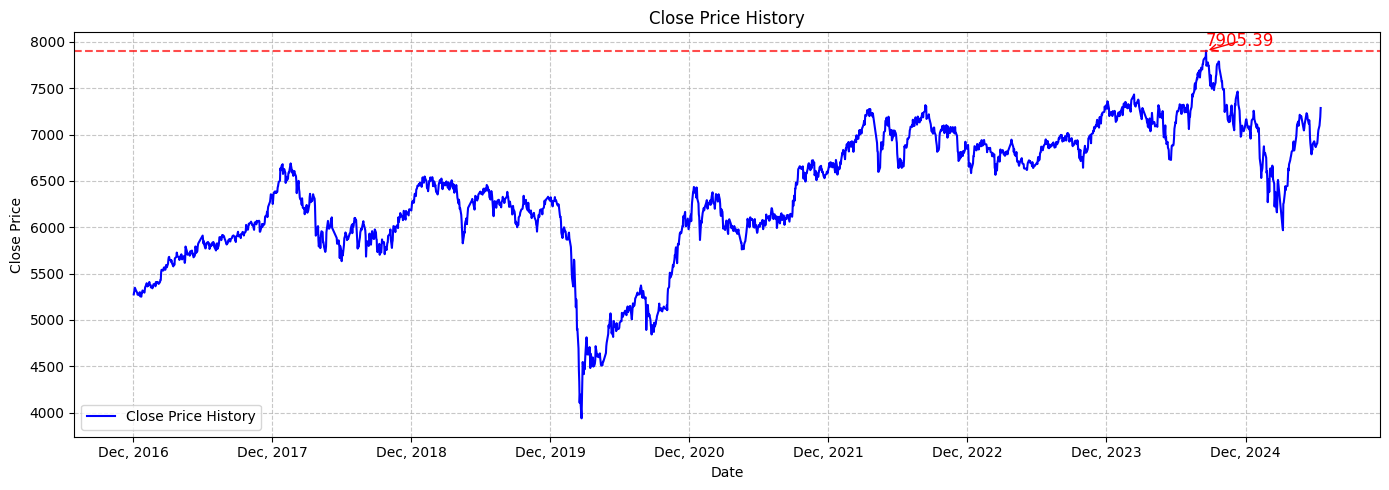

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Buat ukuran figure untuk grafik
plt.figure(figsize=(14, 5))

# Gambar garis harga penutupan (Close) dengan seaborn lineplot
sns.lineplot(data=data, x=data.index, y='Close', label='Close Price History', color='blue')

# Cari nilai maksimum harga penutupan dan tanggalnya
max_price = data['Close'].max()
max_price_date = data['Close'].idxmax()

# Tandai titik harga tertinggi dengan tulisan (annotate)
plt.annotate(f'{max_price:.2f}',  # Tulis nilai maksimal dengan 2 angka di belakang koma
             xy=(max_price_date, max_price),  # Titik yang ditandai (x, y)
             xytext=(max_price_date, max_price + 50),  # Posisi teks sedikit di atas titik
             textcoords='data',
             arrowprops=dict(arrowstyle='->', color='red'),  # Tambah panah
             fontsize=12, color='red')

# Tambahkan garis horizontal di level harga tertinggi
plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)

# Judul dan label sumbu
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format sumbu x agar tanggal terlihat bulanan dan tahun
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b, %Y'))

# Tampilkan grid dan legenda
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# **4.Preprocessing**

---



In [ ]:
'''
Preprocessing (pra-pemrosesan) adalah tahap awal dalam pengolahan data di mana data mentah dibersihkan, disiapkan,
dan diubah menjadi format yang cocok untuk analisis atau pelatihan model.
'''

# Buat objek MinMaxScaler untuk mengubah data ke dalam skala antara 0 dan 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Ambil kolom 'Close', ubah ke bentuk array 2D (n baris × 1 kolom), lalu lakukan normalisasi skala 0–1
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Tampilkan hasil data yang sudah dinormalisasi (berbentuk array 2D)
scaled_data


array([[0.33730361],
       [0.34365781],
       [0.34978741],
       ...,
       [0.80721707],
       [0.82020777],
       [0.8441515 ]])

In [ ]:
def create_sequences(data, squences_length):
  sequences = []
  labels = []
  for i in range(len(data) - squences_length):
    sequences.append(data[i:i+squences_length])
    labels.append(data[i+squences_length,0])
  return np.array(sequences), np.array(labels)

In [ ]:
sequence_length = 30  # Panjang urutan (sequence) yang akan digunakan untuk prediksi

# Tentukan batas antara data training dan testing (80% untuk training)
train_size = int(len(scaled_data) * 0.8)

# Bagi data menjadi training dan testing
train_data = scaled_data[:train_size]  # Data dari awal sampai batas train
test_data = scaled_data[train_size:]   # Data dari batas train sampai akhir

# Buat input (X) dan target (y) untuk data training
X_train, y_train = create_sequences(train_data, sequence_length)

# Buat input (X) dan target (y) untuk data testing
X_test, y_test = create_sequences(test_data, sequence_length)


# **5. Training Data (LTSM)**

---



In [ ]:
model = Sequential()

# 🔹 First LSTM Layer
model.add(Input(shape=(X_train.shape[1], 1)))  # Input shape: (timesteps, features)
model.add(LSTM(units=50, return_sequences=True))  # LSTM dengan 50 unit dan mengembalikan seluruh urutan
model.add(Dropout(0.2))  # Dropout 20% untuk menghindari overfitting

# 🔹 Second LSTM Layer
model.add(LSTM(units=50, return_sequences=False))  # LSTM kedua, hanya mengembalikan output terakhir
model.add(Dropout(0.2))  # Dropout 20% lagi

# 🔹 Dense Layers (Fully connected)
model.add(Dense(units=25))  # Layer dense dengan 25 neuron
model.add(Dense(units=1))   # Output layer dengan 1 neuron (untuk regresi/prediksi harga)

In [ ]:
# Kompilasi model dengan optimizer Adam dan loss function MSE (cocok untuk regresi)
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model dengan data training, selama 2 epoch dan batch size 84
# Juga mengevaluasi performa dengan data validasi (X_test, y_test)
history = model.fit(X_train, y_train, epochs=2, batch_size=84, validation_data=(X_test, y_test))


Epoch 1/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.1019 - val_loss: 0.0241
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0085 - val_loss: 0.0119


# **6. Model Evaluation**

---



In [ ]:
# Gunakan model untuk memprediksi data testing
prediction = model.predict(X_test)

# Kembalikan nilai hasil prediksi ke skala aslinya (dari 0-1 ke harga IHSG asli)
prediction = scaler.inverse_transform(prediction)

# Kembalikan nilai y_test ke skala aslinya juga (reshape agar jadi 2D array)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Hitung Mean Squared Error (MSE) antara prediksi dan nilai sebenarnya
mse = mean_squared_error(y_test_scaled, prediction)

# Tampilkan nilai error
print(f'Mean Squared Error (MSE): {mse:.2f}')


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Mean Squared Error (MSE): 187083.40


# **7. Prediction Future IHSG Price 1 Month**

---



In [ ]:
# Ambil 30 hari terakhir dari data harga penutupan (Close)
last_30_days = data['Close'][-sequence_length:].values.reshape(-1, 1)

# Skala data (gunakan scaler yang sama saat training)
last_30_days_scaled = scaler.transform(last_30_days)

# Siapkan data prediksi
X_predict = []
X_predict.append(last_30_days_scaled)

# Ubah ke array NumPy dan sesuaikan bentuknya agar cocok dengan input model
X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

# Lakukan prediksi harga IHSG dengan model yang sudah dilatih
predicted_price = model.predict(X_predict)

# Kembalikan nilai prediksi ke skala asli (kebalikan dari scaling)
predicted_price = scaler.inverse_transform(predicted_price)

# Tampilkan hasil prediksi
print(f"Predicted IHSG Price: {predicted_price[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted IHSG Price: 6658.02685546875


In [ ]:
# Tentukan jumlah hari ke depan yang ingin diprediksi
future_days = 30

# Ambil 30 hari terakhir dari data
last_30_days = data['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

# List untuk menyimpan hasil prediksi masa depan
future_predictions = []

# Prediksi berulang untuk setiap hari di masa depan
for i in range(future_days):
    X_predict = []
    X_predict.append(last_30_days_scaled)

    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0][0])

    # Update data dengan menambahkan hasil prediksi terbaru, buang data terlama
    new_scaled_data = np.append(last_30_days_scaled[1:], predicted_price, axis=0)
    last_30_days_scaled = new_scaled_data.reshape(-1, 1)

# Buat daftar tanggal prediksi dimulai dari hari terakhir data asli
future_dates = pd.date_range(start=data.index[-1], periods=future_days + 1, freq='D')[1:]

# Buat DataFrame hasil prediksi
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions
})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

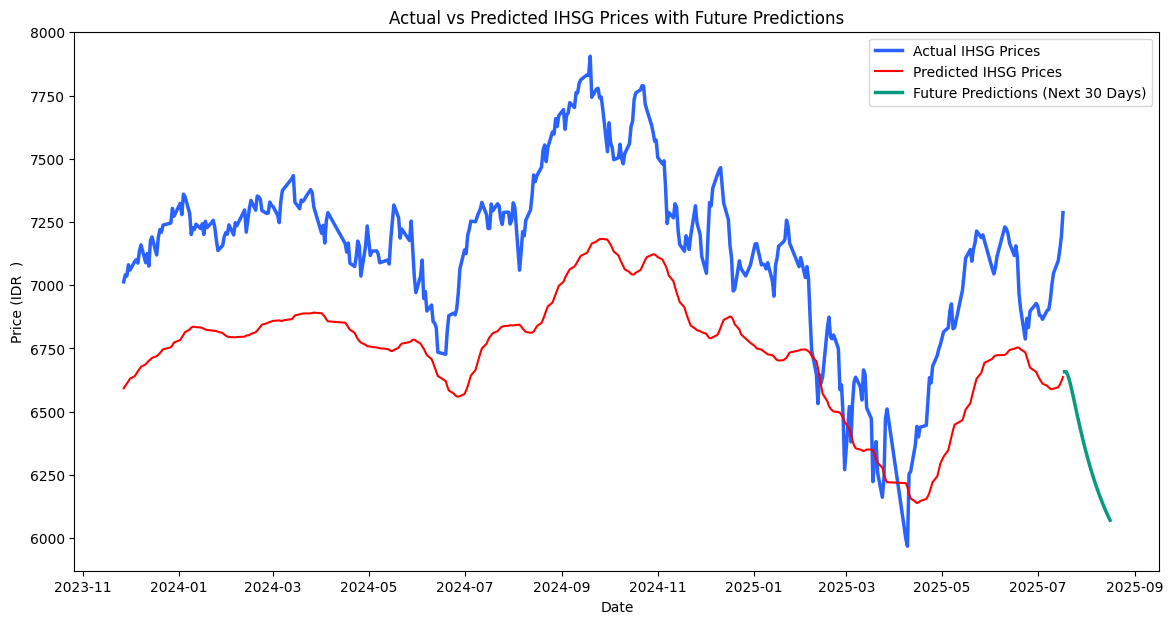

In [ ]:
plt.figure(figsize=(14, 7))

# Plot harga IHSG aktual
plt.plot(data.index[-len(y_test_scaled):], y_test_scaled, label='Actual IHSG Prices', color='#2962ff', linewidth=2.5)

# Plot harga IHSG hasil prediksi model (data test)
plt.plot(data.index[-len(y_test_scaled):],prediction, label='Predicted IHSG Prices', color='red', linewidth=1.5)

# Plot prediksi ke depan (future)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 30 Days)', color='#089981', linewidth=2.5)

# Tambahkan judul dan label sumbu
plt.title('Actual vs Predicted IHSG Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (IDR  )')
plt.legend()

# Tampilkan plot
plt.show()
